In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
%aimport AD_comparison_tools
%aimport AD_predictor_tools
%aimport ADpred_LambertTFs_helper
import protfasta
import matplotlib.pyplot as plt
import seaborn as sns
#import metapredict as meta
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D

sns.set_theme(rc={'figure.figsize':(6,4), 'figure.dpi' : 300})
sns.set_style("white")

from parrot import py_predictor

Error importing GPy.
 If trying to run parrot-optimize, make sure to use `pip install idptools-parrot[optimize]`


In [2]:
human_yeast_preds = pd.read_csv("../output/parrot_human_yeast_aggreg_predictions.tsv",     
            header=None
)
human_yeast_preds["uniprotID"] = human_yeast_preds[0].str.split("_").str[0]
human_yeast_preds["group"] = human_yeast_preds[0].str.split("_").str[1].str.split(" ").str[0]
human_yeast_preds["values"] = human_yeast_preds[0].str.split(" ").str[2:]
human_yeast_preds["values"] = human_yeast_preds["values"].apply(lambda arr: [float(val) for val in arr])
human_yeast_preds = human_yeast_preds[human_yeast_preds["group"] == "PRED"]
human_yeast_preds

,0,uniprotID,group,values
1,P50221_PRED MDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASG...,P50221,PRED,"[-0.02536551, -0.025276393, 0.014549343, 0.017..."
3,Q9Y2T7_PRED MSEVEAAAGATAVPAATVPATAAGVVAVVVPVPA...,Q9Y2T7,PRED,"[-0.030322097, -0.018564384, -0.0069354884, 0...."
5,P56179_PRED MSHSQHSPYLQSYHNSSAAAQTRGDDTDQQKTTV...,P56179,PRED,"[-0.028868772, -0.011867665, -0.0038051158, 0...."
7,P26367_PRED MQNSHSGVNQLGGVFVNGRPLPDSTRQKIVELAH...,P26367,PRED,"[-0.03987664, -0.030328631, -0.017741535, -0.0..."
9,Q99594_PRED MASNSWNASSSPGEAREDGPEGLDKGLDNDAEGV...,Q99594,PRED,"[0.027610231, 0.05781167, 0.08400765, 0.104484..."
...,...,...,...,...
547,Q06639_PRED MDIRGRKMKKPPACVQCRKRKIGCDRVKPICGNC...,Q06639,PRED,"[-0.032519594, -0.025892787, 0.027071085, 0.01..."
549,Q12041_PRED MEDQDAAFIKQATEAIVDVSLNIDNIDPIIKELL...,Q12041,PRED,"[0.06825495, 0.09666946, 0.1030002, 0.08442748..."
551,Q12180_PRED MENQGGDYSPNGFSNSASNMNAVFNNEITGRSDI...,Q12180,PRED,"[-0.0039263405, 0.020346008, 0.038557786, 0.04..."
553,Q12753_PRED MVLINGIKYACERCIRGHRVTTCNHTDQPLMMIK...,Q12753,PRED,"[-0.045882598, -0.04078114, -0.03443741, -0.02..."


In [3]:
human_yeast_preds_input = pd.read_csv("../output/human_yeast_aggreg_preds.tsv",     
            header=None
)
human_yeast_preds_input["uniprotID"] = human_yeast_preds_input[0].str.split(r"\t").str[0]
human_yeast_preds_input["values"] = human_yeast_preds_input[0].str.split(r"\t").str[2:]
human_yeast_preds_input["values"] = human_yeast_preds_input["values"].apply(lambda arr: [float(val) for val in arr if val != ""])
human_yeast_preds_input

,0,uniprotID,values
0,P23511\tMEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTE...,P23511,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Q96QS3\tMSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSP...,Q96QS3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,P31270\tMDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTP...,P31270,"[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ..."
3,P50221\tMDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHY...,P50221,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,P57073\tMLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAG...,P57073,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
1850,Q707Y3\tMPSRTPTDIWRCQRLILAARKGETTCQALHEQSIEISS...,Q707Y3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1851,Q707Y6\tMQFTILNEPSLDSQRREGDLASENYVFGDIRKEGVRIL...,Q707Y6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1852,Q708A1\tMNVQEIHNIREACITILSGTKHNSVLFEPCDKFDEVIN...,Q708A1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1853,Q9HG12\tMCDNDMADIQSKLSSFCEEIRALALKEGYNLEGDKSPS...,Q9HG12,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [4]:
preds = pd.read_csv("../output/parrot_lambert_tf_aggreg_preds_output_predictions.tsv",     
            header=None
)
preds["uniprotID"] = preds[0].str.split("_").str[0]
preds["group"] = preds[0].str.split("_").str[1].str.split(" ").str[0]
preds["values"] = preds[0].str.split(" ").str[2:]
preds["values"] = preds["values"].apply(lambda arr: [float(val) for val in arr])
preds = preds[preds["group"] == "PRED"]
preds

,0,uniprotID,group,values
1,P57073_PRED MLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPP...,P57073,PRED,"[0.020995677, 0.05383175, 0.032915153, 0.06038..."
3,P23759_PRED MAALPGTVPRMMRPAPGQNYPRTGFPLEVSTPLG...,P23759,PRED,"[-0.007915892, 0.0044425353, -0.0033784062, 0...."
5,Q9ULX6_PRED MSYTGFVQGSETTLQSTYSDTSAQPTCDYGYGTW...,Q9ULX6,PRED,"[0.02124333, 0.026465729, 0.039964393, 0.03527..."
7,Q9Y2Y4_PRED MSLPPIRLPSPYGSDRLVQLAARLRPALCDTLIT...,Q9Y2Y4,PRED,"[0.00011461228, 0.0004461184, 0.012523763, 0.0..."
9,P02788_PRED MKLVFLVLLFLGALGLCLAGRRRSVQWCAVSQPE...,P02788,PRED,"[-0.010699801, 0.004176393, 0.002047889, 0.021..."
...,...,...,...,...
473,Q8TD94_PRED MSAAVACLDYFAAECLVSMSAGAVVHRRPPDPEG...,Q8TD94,PRED,"[0.12078214, 0.13988836, 0.14560707, 0.1431540..."
475,A8MQ14_PRED MNMEGLVMFQDLSIDFSQEEWECLDAAQKDLYRD...,A8MQ14,PRED,"[0.5907577, 0.60170156, 0.5752578, 0.59915787,..."
477,Q8IYB9_PRED MELVTFRDVAIEFSPEEWKCLDPAQQNLYRDVML...,Q8IYB9,PRED,"[0.2840611, 0.27889422, 0.2630312, 0.2777081, ..."
479,P48742_PRED MVHCAGCKRPILDRFLLNVLDRAWHVKCVQCCEC...,P48742,PRED,"[0.0031030402, 0.020505667, 0.014487021, 0.016..."


In [5]:
human_preds_input = pd.read_csv("../output/lambert_TF_aggreg_preds.tsv",     
            header=None
)
human_preds_input["uniprotID"] = human_preds_input[0].str.split(r"\t").str[0]
human_preds_input["values"] = human_preds_input[0].str.split(r"\t").str[2:]
human_preds_input["values"] = human_preds_input["values"].apply(lambda arr: [float(val) for val in arr if val != ""])
human_preds_input

,0,uniprotID,values
0,P23511\tMEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTE...,P23511,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Q96QS3\tMSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSP...,Q96QS3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,P31270\tMDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTP...,P31270,"[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ..."
3,P50221\tMDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHY...,P50221,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,P57073\tMLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAG...,P57073,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
1603,P35227\tMHRTTRIKITELNPHLMCALCGGYFIDATTIVECLHSF...,P35227,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1604,Q9BS34\tMDSVSFEDVAVAFTQEEWALLDPSQKNLYRDVMQEIFR...,Q9BS34,"[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ..."
1605,P17098\tMDPEDEGVAGVMSVGPPAARLQEPVTFRDVAVDFTQEE...,P17098,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1606,Q9UJW7\tMETLTSRHEKRALHSQASAISQDREEKIMSQEPLSFKD...,Q9UJW7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [6]:
def find_intervals(arr, threshold=0.4, min_length=10):
    arr = np.array(arr)
    mask = arr >= threshold

    # Find start and end of consecutive True sequences
    diff = np.diff(mask.astype(int))
    starts = np.where(diff == 1)[0] + 1
    ends = np.where(diff == -1)[0] + 1

    # Handle if the sequence starts with True
    if mask[0]:
        starts = np.insert(starts, 0, 0)
    # Handle if the sequence ends with True
    if mask[-1]:
        ends = np.append(ends, len(mask))

    # Filter intervals by length
    intervals = [(start, end) for start, end in zip(starts, ends) if end - start >= min_length]
    return intervals

In [82]:
# If > 0.2 consecutively for > 5 residues, consider it an AD
preds["ADs"] = preds["values"].apply(lambda _: find_intervals(_, threshold =  0.4039))
preds

,0,uniprotID,group,values,ADs
1,P57073_PRED MLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPP...,P57073,PRED,"[0.020995677, 0.05383175, 0.032915153, 0.06038...","[(250, 304)]"
3,P23759_PRED MAALPGTVPRMMRPAPGQNYPRTGFPLEVSTPLG...,P23759,PRED,"[-0.007915892, 0.0044425353, -0.0033784062, 0....",[]
5,Q9ULX6_PRED MSYTGFVQGSETTLQSTYSDTSAQPTCDYGYGTW...,Q9ULX6,PRED,"[0.02124333, 0.026465729, 0.039964393, 0.03527...",[]
7,Q9Y2Y4_PRED MSLPPIRLPSPYGSDRLVQLAARLRPALCDTLIT...,Q9Y2Y4,PRED,"[0.00011461228, 0.0004461184, 0.012523763, 0.0...",[]
9,P02788_PRED MKLVFLVLLFLGALGLCLAGRRRSVQWCAVSQPE...,P02788,PRED,"[-0.010699801, 0.004176393, 0.002047889, 0.021...",[]
...,...,...,...,...,...
473,Q8TD94_PRED MSAAVACLDYFAAECLVSMSAGAVVHRRPPDPEG...,Q8TD94,PRED,"[0.12078214, 0.13988836, 0.14560707, 0.1431540...",[]
475,A8MQ14_PRED MNMEGLVMFQDLSIDFSQEEWECLDAAQKDLYRD...,A8MQ14,PRED,"[0.5907577, 0.60170156, 0.5752578, 0.59915787,...","[(0, 51)]"
477,Q8IYB9_PRED MELVTFRDVAIEFSPEEWKCLDPAQQNLYRDVML...,Q8IYB9,PRED,"[0.2840611, 0.27889422, 0.2630312, 0.2777081, ...",[]
479,P48742_PRED MVHCAGCKRPILDRFLLNVLDRAWHVKCVQCCEC...,P48742,PRED,"[0.0031030402, 0.020505667, 0.014487021, 0.016...","[(258, 306)]"


In [83]:
preds_final = preds.explode("ADs")[["uniprotID", "ADs"]].dropna()
preds_final["Start"] = [interval[0] for interval in preds_final["ADs"]]
preds_final["End"] = [interval[1] for interval in preds_final["ADs"]]
preds_final = preds_final.drop(columns = "ADs")
preds_final

,uniprotID,Start,End
1,P57073,250,304
17,O00409,16,74
23,Q9P0W2,157,180
29,P15923,4,15
31,P36956,0,63
...,...,...,...
461,P49715,76,90
465,Q8NA31,89,103
465,Q8NA31,109,119
475,A8MQ14,0,51


In [84]:
# If > 0.2 consecutively for > 5 residues, consider it an AD
human_preds_input["ADs"] = human_preds_input["values"].apply(lambda _: find_intervals(_, threshold =  0.6))
human_preds_input_final = human_preds_input.explode("ADs")[["uniprotID", "ADs"]].dropna()
human_preds_input_final["Start"] = [interval[0] for interval in human_preds_input_final["ADs"]]
human_preds_input_final["End"] = [interval[1] for interval in human_preds_input_final["ADs"]]
human_preds_input_final = human_preds_input_final.drop(columns = "ADs")
human_preds_input_final

,uniprotID,Start,End
4,P57073,245,312
6,P17010,2,82
8,O14978,188,234
10,P50549,33,87
14,Q14209,360,437
...,...,...,...
1596,P48742,256,316
1602,Q9UI36,607,617
1606,Q9UJW7,13,73
1606,Q9UJW7,129,176


In [85]:
# If > 0.2 consecutively for > 5 residues, consider it an AD
human_yeast_preds["ADs"] = human_yeast_preds["values"].apply(lambda _: find_intervals(_, threshold = 0.2837))
human_yeast_preds_final = human_yeast_preds.explode("ADs")[["uniprotID", "ADs"]].dropna()
human_yeast_preds_final["Start"] = [interval[0] for interval in human_yeast_preds_final["ADs"]]
human_yeast_preds_final["End"] = [interval[1] for interval in human_yeast_preds_final["ADs"]]
human_yeast_preds_final = human_yeast_preds_final.drop(columns = "ADs")
human_yeast_preds_final

,uniprotID,Start,End
9,Q99594,14,31
15,P98182,103,114
15,P98182,123,149
17,Q96GD3,186,209
17,Q96GD3,217,235
...,...,...,...
551,Q12180,920,930
553,Q12753,312,324
553,Q12753,657,694
555,Q707Y3,20,44


In [86]:
# If > 0.2 consecutively for > 5 residues, consider it an AD
human_yeast_preds_input["ADs"] = human_yeast_preds_input["values"].apply(lambda _: find_intervals(_, threshold = 0.6))
human_yeast_preds_input_final = human_yeast_preds_input.explode("ADs")[["uniprotID", "ADs"]].dropna()
human_yeast_preds_input_final["Start"] = [interval[0] for interval in human_yeast_preds_input_final["ADs"]]
human_yeast_preds_input_final["End"] = [interval[1] for interval in human_yeast_preds_input_final["ADs"]]
human_yeast_preds_input_final = human_yeast_preds_input_final.drop(columns = "ADs")
human_yeast_preds_input_final

,uniprotID,Start,End
4,P57073,245,312
6,P17010,2,82
8,O14978,188,234
10,P50549,33,87
14,Q14209,360,437
...,...,...,...
1841,Q12244,539,580
1841,Q12244,769,841
1843,Q12340,743,759
1844,Q12363,64,76


In [87]:
known_ADs= pd.read_csv("../output/known_ADs_considering_isoforms.csv")
known_ADs = known_ADs[known_ADs["TileType"] == "TF"]
#known_ADs = known_ADs[known_ADs["uniprotID"].isin(preds["uniprotID"])]
known_ADs

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes
1,AEBP1,1088,1158,Q8IUX7,[['Q8IUX7']],NaN,Q8IUX7,Staller Activity Data,TF,EVVTEFGTEVEPEFGTKVEPEFETQLEPEFETQLEPEFEEEEEEEK...,NaN
2,AHCTF1,1445,1698,Q8WYP5,"[['Q8WYP5'], ['Q8WYP5']]",nan / nan,Q8WYP5 / Q8WYP5,"PMID: 11952839, Soto / transcriptionalactivity...",TF,IRANDNKSMADVLGDGGNSSLTISEGPIVSERRLNQEVALNLKEDH...,NaN
3,AHR,118,126,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,LLQALNGFV,NaN
4,AHR,266,268,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,FAI,NaN
5,AHR,532,848,P35869,"[['P35869'], ['P35869'], ['P35869']]",ENST00000242057 / nan / ENST00000242057,P35869 / P35869 / P35869,"DelRosso et al. / PMID: 8794892, Soto / DelRos...",TF,QDSKNSDLYSIMKNLGIDFEDIRHMQNEKFFRNDFSGEVDFRDIDL...,NaN
...,...,...,...,...,...,...,...,...,...,...,...
755,ZXDB,576,703,P98169,[['P98169']],NaN,P98169 / P98169,"R4TA_regions.txt / activation_regions.txt, GSL",TF,QDLLAQLEAANSLTPSSELTSQRQNDLSDAEIVSLFSDVPDSTSAA...,NaN
756,ZXDC,579,688,Q2QGD7,"[['Q2QGD7', 'Q2QGD7-2'], ['Q2QGD7', 'Q2QGD7-2']]",nan / nan,Q2QGD7 / Q2QGD7 / Q2QGD7,"PMID: 16600381, Soto / R4TA_regions.txt / acti...",TF,DSPLVLGTAATVLQQGSFSVDDVQTVSAGALGCLVALPMKNLSDDP...,NaN
757,c-ETS1,175,286,P14921-3,[['P14921-3']],NaN,P14921,"Choi 2000 list, GSL",TF,ILQKEDVKPYQVNGVNPAYPESRYTSDYFISYGIEHAQCVPPSEFS...,NaN
758,c-Jun/AP-1,238,257,P05412,[['P05412']],NaN,P05412,"Choi 2000 list, GSL",TF,ETPPLSPIDMESQERIKAER,NaN


In [88]:
def return_tp_fp(preds_input, knownADs):
    preds = preds_input.copy()
    AD_comparison_tools.add_col_contains_prediction(preds, knownADs, result_col_name = "KnownAD")
    TP_count = sum(preds["KnownAD"])
    FP_count = sum(preds["KnownAD"] == False)
    print("True positives: " + str(TP_count) + "(" + str(np.round((100 * TP_count/ len(preds)), 1)) + "%)")
    print("False positives: " + str(FP_count)+ "(" + str(np.round((100 * FP_count/ len(preds)), 1)) + "%)")
    return TP_count, FP_count

In [89]:
return_tp_fp(preds_final, known_ADs)

True positives: 41(28.7%)
False positives: 102(71.3%)


(41, 102)

### 1b. Assuming Known ADs represent real truth, use only acidic known ADs
"Second, repeated this assessment only using acidic ADs. This assessment estimates the minimum performance of our model."

In [90]:
known_ADs["charge"] = known_ADs["ProteinRegionSeq"].str.count("R") \
    + known_ADs["ProteinRegionSeq"].str.count("K") \
    - known_ADs["ProteinRegionSeq"].str.count("D") \
    - known_ADs["ProteinRegionSeq"].str.count("E")
acidic_known_ADs = known_ADs[known_ADs["charge"] < -3]
len(acidic_known_ADs)   

402

In [91]:
return_tp_fp(preds_input = preds_final, knownADs = acidic_known_ADs)

True positives: 40(28.0%)
False positives: 103(72.0%)


(40, 103)

### 2a. Limit assessment to only predictions on TFs containing at least one known AD.
"Third, we limited our assessment of model performance by only looking at TFs that contained at least one entry on the GSL or Soto lists, assuming for a moment that all ADs on these TFs are known. Now the performance is X, which is much better. "

In [92]:
known_ADs[known_ADs["uniprotID"].isin(preds["uniprotID"])]

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes,charge
8,AKAP8L,1,384,Q9ULX6,"[['Q9ULX6'], ['Q9ULX6'], ['Q9ULX6']]",nan / nan / ENST00000397410,Q9ULX6 / Q9ULX6 / Q9ULX6,"PMID: 11402034, Soto / activation_regions.txt,...",TF,MSYTGFVQGSETTLQSTYSDTSAQPTCDYGYGTWNSGTNRGYEGYG...,NaN,-13
21,ARNT2,524,717,Q9HBZ2,[['Q9HBZ2']],NaN,Q9HBZ2,"PMID: 8657146, Soto",TF,QGSPFPSGHSGKAFSSSVVHVPGVNDIQSSSSTGQNMSQISRQLNQ...,NaN,-6
33,ATF6A / ATF6 / ATF6alpha / ATF6,1,150,P18850,"[['P18850'], ['P18850'], ['P18850'], ['P18850'...",nan / nan / ENST00000367942 / nan / ENST000003...,P18850 / P18850 / P18850 / P18850 / P18850 / P...,"PMID: 10958673, Soto / activation_regions.txt ...",TF,MGEPAGVAGTMESPFSPGLFHRLDEDWDSALFAELGYFTDTDELQL...,NaN,-24
56,CDX1,1,162,P47902,[['P47902']],NaN,P47902,"PMID: 15143193, Soto",TF,MYVGYVLDKDSPVYPGPARPASLGLGPQAYGPPAPPPAPPQYPDFS...,NaN,2
59,CEBPA,1,199,P49715,"[['P49715'], ['P49715'], ['P49715'], ['P49715'...",nan / ENST00000498907 / ENST00000498907 / nan ...,P49715 / P49715 / P49715 / P49715 / P49715 / P...,"PMID: 8314088, Soto / DelRosso et al. / DelRos...",TF,MESADFYEAEPRPPMSSHLQSPPHAPSSAAFGFPRGAGPAQPPAPP...,NaN,-12
...,...,...,...,...,...,...,...,...,...,...,...,...
687,TP63,610,680,Q9H3D4,[['Q9H3D4']],NaN,Q9H3D4,"activation_regions.txt, GSL",TF,FSSPSHLLRTPSSASTVSVGSSETRGERVIDAVRFTLRQTISFPPR...,NaN,0
734,ZN654,680,724,Q8IZM8,[['Q8IZM8']],NaN,Q8IZM8,Staller Activity Data,TF,GSPNNSLNNVFKPLTECGDDYEEEEDEEGDYEEDDYDLNQETSVI,NaN,-16
735,ZN777,454,495,Q9ULD5,[['Q9ULD5']],NaN,Q9ULD5,Staller Activity Data,TF,EEQDEEEEEEEEDELPQHLQSLGQLSGRYEASMYQTPLPGEM,NaN,-14
742,ZNF326,1,124,Q5BKZ1,"[['Q5BKZ1'], ['Q5BKZ1']]",nan / nan,Q5BKZ1 / Q5BKZ1,"PMID: 30401956, Soto / activation_regions.txt,...",TF,MDFEDDYTHSACRNTYQGFNGMDRDYGPGSYGGMDRDYGHGSYGGQ...,NaN,-6


In [93]:
known_ADs[known_ADs["uniprotID"].isin(human_yeast_preds["uniprotID"])]

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes,charge
1,AEBP1,1088,1158,Q8IUX7,[['Q8IUX7']],NaN,Q8IUX7,Staller Activity Data,TF,EVVTEFGTEVEPEFGTKVEPEFETQLEPEFETQLEPEFEEEEEEEK...,NaN,-23
61,CEBPD,12,121,P49716,"[['P49716'], ['P49716']]",ENST00000408965 / nan,P49716 / P49716,"DelRosso et al. / PMID: 12791769, Soto",TF,ARGAPWPAEPAPFYEPGRAGKPGRGAEPGALGEPGAAAPAMYDDES...,NaN,-5
71,CR3L1 / CREB3L1,1,101,Q96BA8,"[['Q96BA8', 'Q96BA8-2'], ['Q96BA8', 'Q96BA8-2'...",nan / nan / ENST00000621158 / nan,Q96BA8 / Q96BA8 / Q96BA8 / Q96BA8 / Q96BA8,"PMID: 12054625, Soto / R4TA_regions.txt / acti...",TF,MDAVLEPFPADRLFPGSSFLDLGDLNESDFLNNAHFPEHLDHFTEN...,NaN,-20
73,CREB1,151,238,P16220,[['P16220']],NaN,P16220,"Choi 2000 list, GSL",TF,ITTVTVPTPIYQTSSGQYIAITQGGAIQLANNGTDGVQGLQTLTMT...,NaN,-3
77,CREB3L2,1,111,Q70SY1,"[['Q70SY1', 'Q70SY1-2', 'Q70SY1-3'], ['Q70SY1'...",nan / ENST00000330387,Q70SY1 / Q70SY1,"PMID: 17117415, Soto / DelRosso et al.",TF,MEVLESGEQGVLQWDRKLSELSEPGDGEALMYHTHFSELLDEFSQN...,NaN,-19
...,...,...,...,...,...,...,...,...,...,...,...,...
718,ZBTB17,637,803,Q13105,[['Q13105']],NaN,Q13105,"PMID: 12244100, Soto",TF,HQGKAGIKILEPEEGSEVSVVTVDDMVTLATEALAATAVTQLTVVP...,NaN,-16
733,ZN644,852,893,Q9H582,"[['Q9H582', 'Q9H582-2']]",NaN,Q9H582,Staller Activity Data,TF,SYETEDESSWDNVELGDYTTQAIEDETYSDINQEHVNLFPLF,NaN,-12
740,ZNF200,52,151,P98182,"[['P98182', 'P98182-3']]",ENST00000431561,P98182,DelRosso et al.,TF,TFLPKPSLVQPSQKVKETLVIMKDVSSSLQNRVHPRPLVKLLPKGV...,NaN,-5
751,ZNF644,902,981,Q9H582,"[['Q9H582', 'Q9H582-2']]",ENST00000337393,Q9H582,DelRosso et al.,TF,PGENATLSYDQNDGFYFEYYEDTGSNNFLHEIHDPQHLETADASLS...,NaN,-10


In [94]:
TF_lim_preds = preds_final[preds_final["uniprotID"].isin(known_ADs["uniprotID"])]
display(len(TF_lim_preds))
return_tp_fp(preds_input = TF_lim_preds, knownADs = known_ADs)

54

True positives: 41(75.9%)
False positives: 13(24.1%)


(41, 13)

In [97]:
known_ADs[known_ADs["uniprotID"].isin(human_preds_input["uniprotID"])]

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes,charge
1,AEBP1,1088,1158,Q8IUX7,[['Q8IUX7']],NaN,Q8IUX7,Staller Activity Data,TF,EVVTEFGTEVEPEFGTKVEPEFETQLEPEFETQLEPEFEEEEEEEK...,NaN,-23
2,AHCTF1,1445,1698,Q8WYP5,"[['Q8WYP5'], ['Q8WYP5']]",nan / nan,Q8WYP5 / Q8WYP5,"PMID: 11952839, Soto / transcriptionalactivity...",TF,IRANDNKSMADVLGDGGNSSLTISEGPIVSERRLNQEVALNLKEDH...,NaN,-36
3,AHR,118,126,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,LLQALNGFV,NaN,0
4,AHR,266,268,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,FAI,NaN,0
5,AHR,532,848,P35869,"[['P35869'], ['P35869'], ['P35869']]",ENST00000242057 / nan / ENST00000242057,P35869 / P35869 / P35869,"DelRosso et al. / PMID: 8794892, Soto / DelRos...",TF,QDSKNSDLYSIMKNLGIDFEDIRHMQNEKFFRNDFSGEVDFRDIDL...,NaN,-20
...,...,...,...,...,...,...,...,...,...,...,...,...
754,ZXDA,572,699,P98168,"[['P98168'], ['P98168']]",nan / nan,P98168 / P98168 / P98168,"PMID: 17493635, Soto / R4TA_regions.txt / acti...",TF,QDLLAQLEAANSLTPSSELTSQRQNDLSDAEIVSLFSDVPDSTSAA...,NaN,-14
755,ZXDB,576,703,P98169,[['P98169']],NaN,P98169 / P98169,"R4TA_regions.txt / activation_regions.txt, GSL",TF,QDLLAQLEAANSLTPSSELTSQRQNDLSDAEIVSLFSDVPDSTSAA...,NaN,-14
756,ZXDC,579,688,Q2QGD7,"[['Q2QGD7', 'Q2QGD7-2'], ['Q2QGD7', 'Q2QGD7-2']]",nan / nan,Q2QGD7 / Q2QGD7 / Q2QGD7,"PMID: 16600381, Soto / R4TA_regions.txt / acti...",TF,DSPLVLGTAATVLQQGSFSVDDVQTVSAGALGCLVALPMKNLSDDP...,NaN,-6
758,c-Jun/AP-1,238,257,P05412,[['P05412']],NaN,P05412,"Choi 2000 list, GSL",TF,ETPPLSPIDMESQERIKAER,NaN,-2


In [68]:
TF_lim_preds_human_input = human_preds_input_final[human_preds_input_final["uniprotID"].isin(known_ADs["uniprotID"])]
display(TF_lim_preds_human_input)
return_tp_fp(preds_input = TF_lim_preds_human_input, knownADs = known_ADs)

,uniprotID,Start,End
4,P57073,245,312
6,P17010,2,82
10,P50549,33,87
14,Q14209,360,437
19,Q9NP71,223,336
...,...,...,...
1576,Q9UBX2,343,410
1590,Q01892,9,67
1592,Q9UMN6,1955,2018
1592,Q9UMN6,2346,2386


True positives: 236(71.3%)
False positives: 95(28.7%)


(236, 95)

In [48]:
TF_lim_preds_human_yeast = human_yeast_preds_final[human_yeast_preds_final["uniprotID"].isin(known_ADs["uniprotID"])]
display(TF_lim_preds_human_yeast)
return_tp_fp(preds_input = TF_lim_preds_human_yeast, knownADs = known_ADs)

,uniprotID,Start,End
9,Q99594,14,31
15,P98182,103,114
15,P98182,123,149
35,Q68CJ9,0,95
61,Q13469,4,73
...,...,...,...
429,Q8WWB7,318,346
445,Q06416,0,65
457,P49716,32,105
459,Q96MW7,404,500


True positives: 44(56.4%)
False positives: 34(43.6%)


(44, 34)

In [49]:
known_ADs[known_ADs["uniprotID"].isin(human_yeast_preds_input_final["uniprotID"])]

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes,pred,avg_pred
1,AEBP1,1088,1158,Q8IUX7,[['Q8IUX7']],NaN,Q8IUX7,Staller Activity Data,TF,EVVTEFGTEVEPEFGTKVEPEFETQLEPEFETQLEPEFEEEEEEEK...,NaN,"[0.49597177, 0.5052103, 0.5114719, 0.50486827,...",0.569230
2,AHCTF1,1445,1698,Q8WYP5,"[['Q8WYP5'], ['Q8WYP5']]",nan / nan,Q8WYP5 / Q8WYP5,"PMID: 11952839, Soto / transcriptionalactivity...",TF,IRANDNKSMADVLGDGGNSSLTISEGPIVSERRLNQEVALNLKEDH...,NaN,"[0.062776566, 0.03597583, 0.020370468, 0.01454...",0.253974
3,AHR,118,126,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,LLQALNGFV,NaN,"[0.11718014, 0.14101821, 0.13413888, 0.1254298...",0.123268
4,AHR,266,268,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,FAI,NaN,"[0.167359, 0.13148099, 0.11567037]",0.138170
5,AHR,532,848,P35869,"[['P35869'], ['P35869'], ['P35869']]",ENST00000242057 / nan / ENST00000242057,P35869 / P35869 / P35869,"DelRosso et al. / PMID: 8794892, Soto / DelRos...",TF,QDSKNSDLYSIMKNLGIDFEDIRHMQNEKFFRNDFSGEVDFRDIDL...,NaN,"[0.4469427, 0.44290623, 0.38474098, 0.38282666...",0.295597
...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,ZNF644,902,981,Q9H582,"[['Q9H582', 'Q9H582-2']]",ENST00000337393,Q9H582,DelRosso et al.,TF,PGENATLSYDQNDGFYFEYYEDTGSNNFLHEIHDPQHLETADASLS...,NaN,"[0.5975487, 0.58377296, 0.5817924, 0.57509816,...",0.454689
752,ZNF687,2,81,Q8N1G0,"[['Q8N1G0', 'Q8N1G0-2']]",ENST00000324048,Q8N1G0,DelRosso et al.,TF,GDMKTPDFDDLLAAFDIPDIDANEAIHSGPEENEGPGGPGKPEPGV...,NaN,"[0.60299826, 0.5899631, 0.49887297, 0.47277847...",0.228970
753,ZSCAN20,262,341,P17040,"[['P17040', 'P17040-3']]",ENST00000361328,P17040,DelRosso et al.,TF,PSNTSEKEQGPEFWGLSLINSGKRSTADYSLDNEPAQALTWRDSRA...,NaN,"[0.14020018, 0.14320584, 0.14790076, 0.1694089...",0.313993
755,ZXDB,576,703,P98169,[['P98169']],NaN,P98169 / P98169,"R4TA_regions.txt / activation_regions.txt, GSL",TF,QDLLAQLEAANSLTPSSELTSQRQNDLSDAEIVSLFSDVPDSTSAA...,NaN,"[0.21528965, 0.20046726, 0.15733227, 0.1891358...",0.238041


In [50]:
TF_lim_preds_human_yeast_input = human_yeast_preds_input_final[human_yeast_preds_input_final["uniprotID"].isin(known_ADs["uniprotID"])]
display(TF_lim_preds_human_yeast_input)
return_tp_fp(preds_input = TF_lim_preds_human_yeast_input, knownADs = known_ADs)

,uniprotID,Start,End
4,P57073,245,312
6,P17010,2,82
10,P50549,33,87
14,Q14209,360,437
19,Q9NP71,223,336
...,...,...,...
1576,Q9UBX2,343,410
1590,Q01892,9,67
1592,Q9UMN6,1955,2018
1592,Q9UMN6,2346,2386


True positives: 236(71.3%)
False positives: 95(28.7%)


(236, 95)

### 2b. Limiting assessment to only predictions on TFs containing at least one known AD, use only acidic known ADs.
"Fourth, we repeated this assessment using only acidic ADs."

In [24]:
len(acidic_known_ADs)

402

In [25]:
acidic_known_ADs_TF_lim_preds = preds_final[preds_final["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
return_tp_fp(preds_input = acidic_known_ADs_TF_lim_preds, knownADs = acidic_known_ADs)

True positives: 40(83.3%)
False positives: 8(16.7%)


(40, 8)

In [26]:
len(acidic_known_ADs_TF_lim_preds)

48

In [27]:
known_ADs = pd.read_csv("../output/known_ADs_considering_isoforms.csv")
known_ADs

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes
0,ABRAXAS1,121,200,Q6UWZ7,[['Q6UWZ7']],ENST00000321945,Q6UWZ7,DelRosso et al.,CR,LQEHFSNQDLVFLLLTPSIITESCSTHRLEHSLYKPQKGLFHRVPL...,NaN
1,AEBP1,1088,1158,Q8IUX7,[['Q8IUX7']],NaN,Q8IUX7,Staller Activity Data,TF,EVVTEFGTEVEPEFGTKVEPEFETQLEPEFETQLEPEFEEEEEEEK...,NaN
2,AHCTF1,1445,1698,Q8WYP5,"[['Q8WYP5'], ['Q8WYP5']]",nan / nan,Q8WYP5 / Q8WYP5,"PMID: 11952839, Soto / transcriptionalactivity...",TF,IRANDNKSMADVLGDGGNSSLTISEGPIVSERRLNQEVALNLKEDH...,NaN
3,AHR,118,126,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,LLQALNGFV,NaN
4,AHR,266,268,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,FAI,NaN
...,...,...,...,...,...,...,...,...,...,...,...
755,ZXDB,576,703,P98169,[['P98169']],NaN,P98169 / P98169,"R4TA_regions.txt / activation_regions.txt, GSL",TF,QDLLAQLEAANSLTPSSELTSQRQNDLSDAEIVSLFSDVPDSTSAA...,NaN
756,ZXDC,579,688,Q2QGD7,"[['Q2QGD7', 'Q2QGD7-2'], ['Q2QGD7', 'Q2QGD7-2']]",nan / nan,Q2QGD7 / Q2QGD7 / Q2QGD7,"PMID: 16600381, Soto / R4TA_regions.txt / acti...",TF,DSPLVLGTAATVLQQGSFSVDDVQTVSAGALGCLVALPMKNLSDDP...,NaN
757,c-ETS1,175,286,P14921-3,[['P14921-3']],NaN,P14921,"Choi 2000 list, GSL",TF,ILQKEDVKPYQVNGVNPAYPESRYTSDYFISYGIEHAQCVPPSEFS...,NaN
758,c-Jun/AP-1,238,257,P05412,[['P05412']],NaN,P05412,"Choi 2000 list, GSL",TF,ETPPLSPIDMESQERIKAER,NaN


# Other

In [28]:
my_predictor = py_predictor.Predictor("../output/parrot_lambert_tf_aggreg_preds_output", 
                                                dtype="residues")

In [29]:
known_ADs["pred"] = known_ADs["ProteinRegionSeq"].apply(lambda seq: my_predictor.predict(seq))
known_ADs["avg_pred"] = known_ADs["pred"].apply(lambda preds: np.average(preds))
known_ADs

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes,pred,avg_pred
0,ABRAXAS1,121,200,Q6UWZ7,[['Q6UWZ7']],ENST00000321945,Q6UWZ7,DelRosso et al.,CR,LQEHFSNQDLVFLLLTPSIITESCSTHRLEHSLYKPQKGLFHRVPL...,NaN,"[0.21440402, 0.1985035, 0.19672097, 0.15478206...",0.062652
1,AEBP1,1088,1158,Q8IUX7,[['Q8IUX7']],NaN,Q8IUX7,Staller Activity Data,TF,EVVTEFGTEVEPEFGTKVEPEFETQLEPEFETQLEPEFEEEEEEEK...,NaN,"[0.49597177, 0.5052103, 0.5114719, 0.50486827,...",0.569230
2,AHCTF1,1445,1698,Q8WYP5,"[['Q8WYP5'], ['Q8WYP5']]",nan / nan,Q8WYP5 / Q8WYP5,"PMID: 11952839, Soto / transcriptionalactivity...",TF,IRANDNKSMADVLGDGGNSSLTISEGPIVSERRLNQEVALNLKEDH...,NaN,"[0.062776566, 0.03597583, 0.020370468, 0.01454...",0.253974
3,AHR,118,126,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,LLQALNGFV,NaN,"[0.11718014, 0.14101821, 0.13413888, 0.1254298...",0.123268
4,AHR,266,268,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,FAI,NaN,"[0.167359, 0.13148099, 0.11567037]",0.138170
...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,ZXDB,576,703,P98169,[['P98169']],NaN,P98169 / P98169,"R4TA_regions.txt / activation_regions.txt, GSL",TF,QDLLAQLEAANSLTPSSELTSQRQNDLSDAEIVSLFSDVPDSTSAA...,NaN,"[0.21528965, 0.20046726, 0.15733227, 0.1891358...",0.238041
756,ZXDC,579,688,Q2QGD7,"[['Q2QGD7', 'Q2QGD7-2'], ['Q2QGD7', 'Q2QGD7-2']]",nan / nan,Q2QGD7 / Q2QGD7 / Q2QGD7,"PMID: 16600381, Soto / R4TA_regions.txt / acti...",TF,DSPLVLGTAATVLQQGSFSVDDVQTVSAGALGCLVALPMKNLSDDP...,NaN,"[0.06314743, 0.019462157, 0.015291005, 0.01762...",0.025067
757,c-ETS1,175,286,P14921-3,[['P14921-3']],NaN,P14921,"Choi 2000 list, GSL",TF,ILQKEDVKPYQVNGVNPAYPESRYTSDYFISYGIEHAQCVPPSEFS...,NaN,"[0.08097392, 0.0955452, 0.08989921, 0.05627999...",0.276773
758,c-Jun/AP-1,238,257,P05412,[['P05412']],NaN,P05412,"Choi 2000 list, GSL",TF,ETPPLSPIDMESQERIKAER,NaN,"[0.068042986, 0.06651746, 0.05170112, 0.047614...",0.053213


<Axes: xlabel='avg_pred', ylabel='Count'>

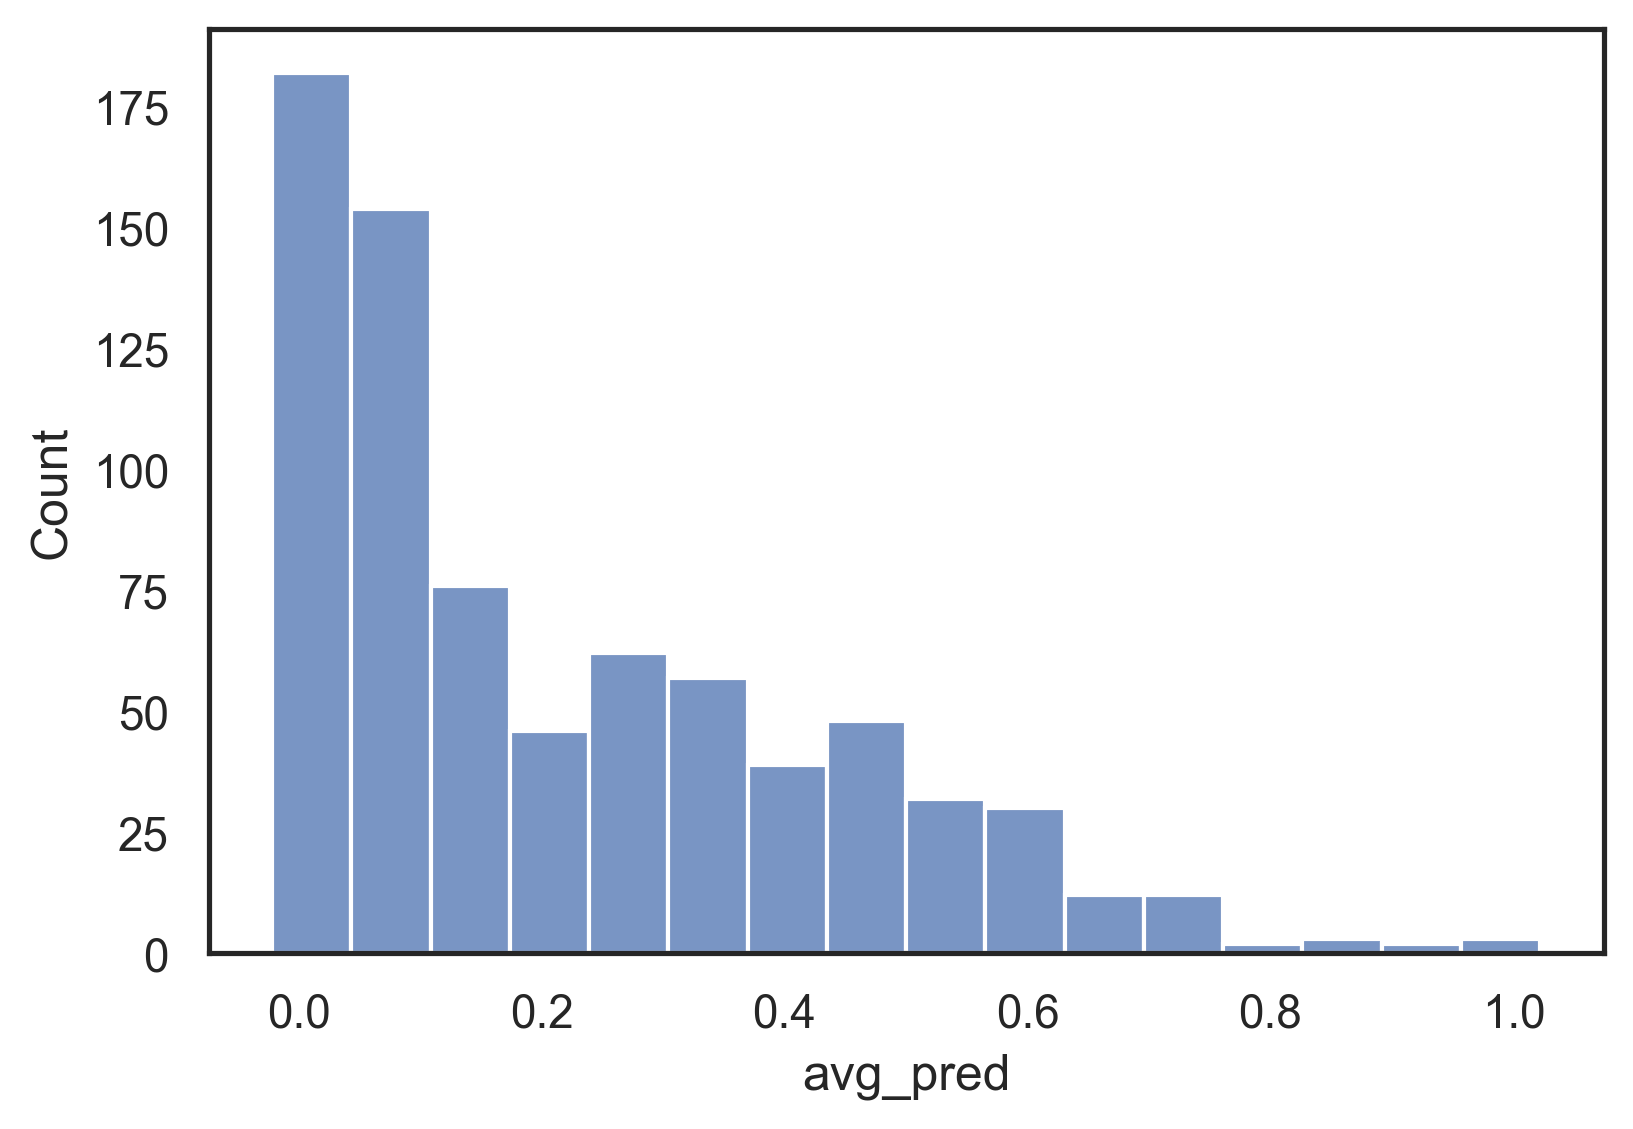

In [30]:
sns.histplot(known_ADs["avg_pred"])

In [31]:
test_ADs = known_ADs[known_ADs["uniprotID"].isin(preds['uniprotID'])]
test_ADs

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes,pred,avg_pred
8,AKAP8L,1,384,Q9ULX6,"[['Q9ULX6'], ['Q9ULX6'], ['Q9ULX6']]",nan / nan / ENST00000397410,Q9ULX6 / Q9ULX6 / Q9ULX6,"PMID: 11402034, Soto / activation_regions.txt,...",TF,MSYTGFVQGSETTLQSTYSDTSAQPTCDYGYGTWNSGTNRGYEGYG...,NaN,"[0.02124333, 0.026465729, 0.039964393, 0.03527...",0.073365
21,ARNT2,524,717,Q9HBZ2,[['Q9HBZ2']],NaN,Q9HBZ2,"PMID: 8657146, Soto",TF,QGSPFPSGHSGKAFSSSVVHVPGVNDIQSSSSTGQNMSQISRQLNQ...,NaN,"[0.041125536, 0.022748113, 0.0061373115, -0.00...",0.170619
33,ATF6A / ATF6 / ATF6alpha / ATF6,1,150,P18850,"[['P18850'], ['P18850'], ['P18850'], ['P18850'...",nan / nan / ENST00000367942 / nan / ENST000003...,P18850 / P18850 / P18850 / P18850 / P18850 / P...,"PMID: 10958673, Soto / activation_regions.txt ...",TF,MGEPAGVAGTMESPFSPGLFHRLDEDWDSALFAELGYFTDTDELQL...,NaN,"[0.47051775, 0.4754828, 0.4975764, 0.4920691, ...",0.586835
56,CDX1,1,162,P47902,[['P47902']],NaN,P47902,"PMID: 15143193, Soto",TF,MYVGYVLDKDSPVYPGPARPASLGLGPQAYGPPAPPPAPPQYPDFS...,NaN,"[0.013919972, 0.049276836, 0.046198037, 0.0305...",0.052017
59,CEBPA,1,199,P49715,"[['P49715'], ['P49715'], ['P49715'], ['P49715'...",nan / ENST00000498907 / ENST00000498907 / nan ...,P49715 / P49715 / P49715 / P49715 / P49715 / P...,"PMID: 8314088, Soto / DelRosso et al. / DelRos...",TF,MESADFYEAEPRPPMSSHLQSPPHAPSSAAFGFPRGAGPAQPPAPP...,NaN,"[0.10703482, 0.095763065, 0.08818154, 0.088931...",0.177528
...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,TP63,610,680,Q9H3D4,[['Q9H3D4']],NaN,Q9H3D4,"activation_regions.txt, GSL",TF,FSSPSHLLRTPSSASTVSVGSSETRGERVIDAVRFTLRQTISFPPR...,NaN,"[0.071874276, 0.05904542, 0.034522366, 0.02305...",0.188694
734,ZN654,680,724,Q8IZM8,[['Q8IZM8']],NaN,Q8IZM8,Staller Activity Data,TF,GSPNNSLNNVFKPLTECGDDYEEEEDEEGDYEEDDYDLNQETSVI,NaN,"[0.30361888, 0.323104, 0.32387713, 0.33514088,...",0.335275
735,ZN777,454,495,Q9ULD5,[['Q9ULD5']],NaN,Q9ULD5,Staller Activity Data,TF,EEQDEEEEEEEEDELPQHLQSLGQLSGRYEASMYQTPLPGEM,NaN,"[0.028794996, 0.04161235, 0.06607952, 0.019133...",0.053542
742,ZNF326,1,124,Q5BKZ1,"[['Q5BKZ1'], ['Q5BKZ1']]",nan / nan,Q5BKZ1 / Q5BKZ1,"PMID: 30401956, Soto / activation_regions.txt,...",TF,MDFEDDYTHSACRNTYQGFNGMDRDYGPGSYGGMDRDYGHGSYGGQ...,NaN,"[0.11311392, 0.10741022, 0.14230175, 0.1157481...",0.059260


In [32]:
test_ADs.sort_values(by = "avg_pred")

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes,pred,avg_pred
564,RXRB,1,201,P28702,"[['P28702', 'P28702-3']]",NaN,P28702,"PMID: 20674387, Soto",TF,MSWAARPPFLPQRHAAGQCGPVGVRKEMHCGVASRWRRRRPWLDPA...,NaN,"[0.014036842, 0.018377513, 0.04921688, 0.03869...",-0.000736
566,RXRG,1,103,P48443,[['P48443']],NaN,P48443,"PMID: 8628649, Soto",TF,MYGNYSHFMKFPAGYGGSPGHTGSTSMSPSAALSTGKPMDSHPSYT...,NaN,"[0.008629836, 0.043740034, 0.02212657, 0.01119...",0.003241
426,NKX6-1,261,367,P78426,[['P78426']],NaN,P78426,"PMID: 15056733, Soto",TF,LAGPERARLAYSLGMTESQVKVWFQNRRTKWRKKHAAEMATAKKKQ...,NaN,"[0.06745682, 0.057257585, 0.039540462, 0.02754...",0.005552
335,MEF2A,87,499,Q02078,"[['Q02078'], ['Q02078']]",nan / nan,Q02078 / Q02078,"PMID: 9891782, 11904443, Soto / Choi 2000 list...",TF,ALNKKEHRGCDSPDPDTSYVLTPHTEEKYKKINEEFDNMMRNHKIA...,NaN,"[0.034191728, 0.042931028, 0.045984544, 0.0259...",0.013525
369,MYOD1,167,320,P15172,[['P15172']],NaN,P15172,"PMID: 9710631, Soto",TF,QDAAPPGAAAAFYAPGPLPPGRGGEHYSGDSDASSPRSNCSDGMMD...,NaN,"[0.057019524, 0.032541595, 0.03528618, 0.02319...",0.013630
...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,HSF1,362,529,Q00613,"[['Q00613'], ['Q00613', 'Q00613-2'], ['Q00613'...",ENST00000528838 / nan / nan / nan,Q00613 / Q00613 / Q00613 / Q00613 / Q00613,"DelRosso et al. / PMID: 7760831, Soto / Choi 2...",TF,PSPPPTSTPEKCLSVACLDKNELSDHLDAMDSNLDNLQTMLSSHGF...,NaN,"[0.18924095, 0.2033457, 0.21204811, 0.23089078...",0.588504
239,HIF3A,454,510,Q9Y2N7,"[['Q9Y2N7', 'Q9Y2N7-3'], ['Q9Y2N7', 'Q9Y2N7-3']]",nan / nan,Q9Y2N7 / Q9Y2N7,"TAD_regions.txt, GSL / PMID: 9840812, Soto",TF,VGTENVHRLFTSGKDTEAVETDLDIAQDADALDLEMLAPYISMDDD...,NaN,"[0.26534006, 0.27261162, 0.29275775, 0.3344946...",0.632873
85,CSRNP1,482,589,Q96S65,"[['Q96S65'], ['Q96S65']]",ENST00000273153 / nan,Q96S65 / Q96S65,"DelRosso et al. / PMID: 17726538, Soto",TF,SVPPSMDAGRSSSVDLSLSSCDSFELLQALPDYSLGPHYTSQKVSD...,NaN,"[0.39976606, 0.41946775, 0.42519292, 0.4299937...",0.701486
416,NFKB1,745,788,P19838,[['P19838']],NaN,P19838,Staller Activity Data,TF,PLVENFEPLYDLDDSWENAGEDEGVVPGTTPLDMATSWQVFDIL,NaN,"[0.62158906, 0.6512682, 0.62929934, 0.6298334,...",0.760063


<Axes: xlabel='avg_pred', ylabel='Count'>

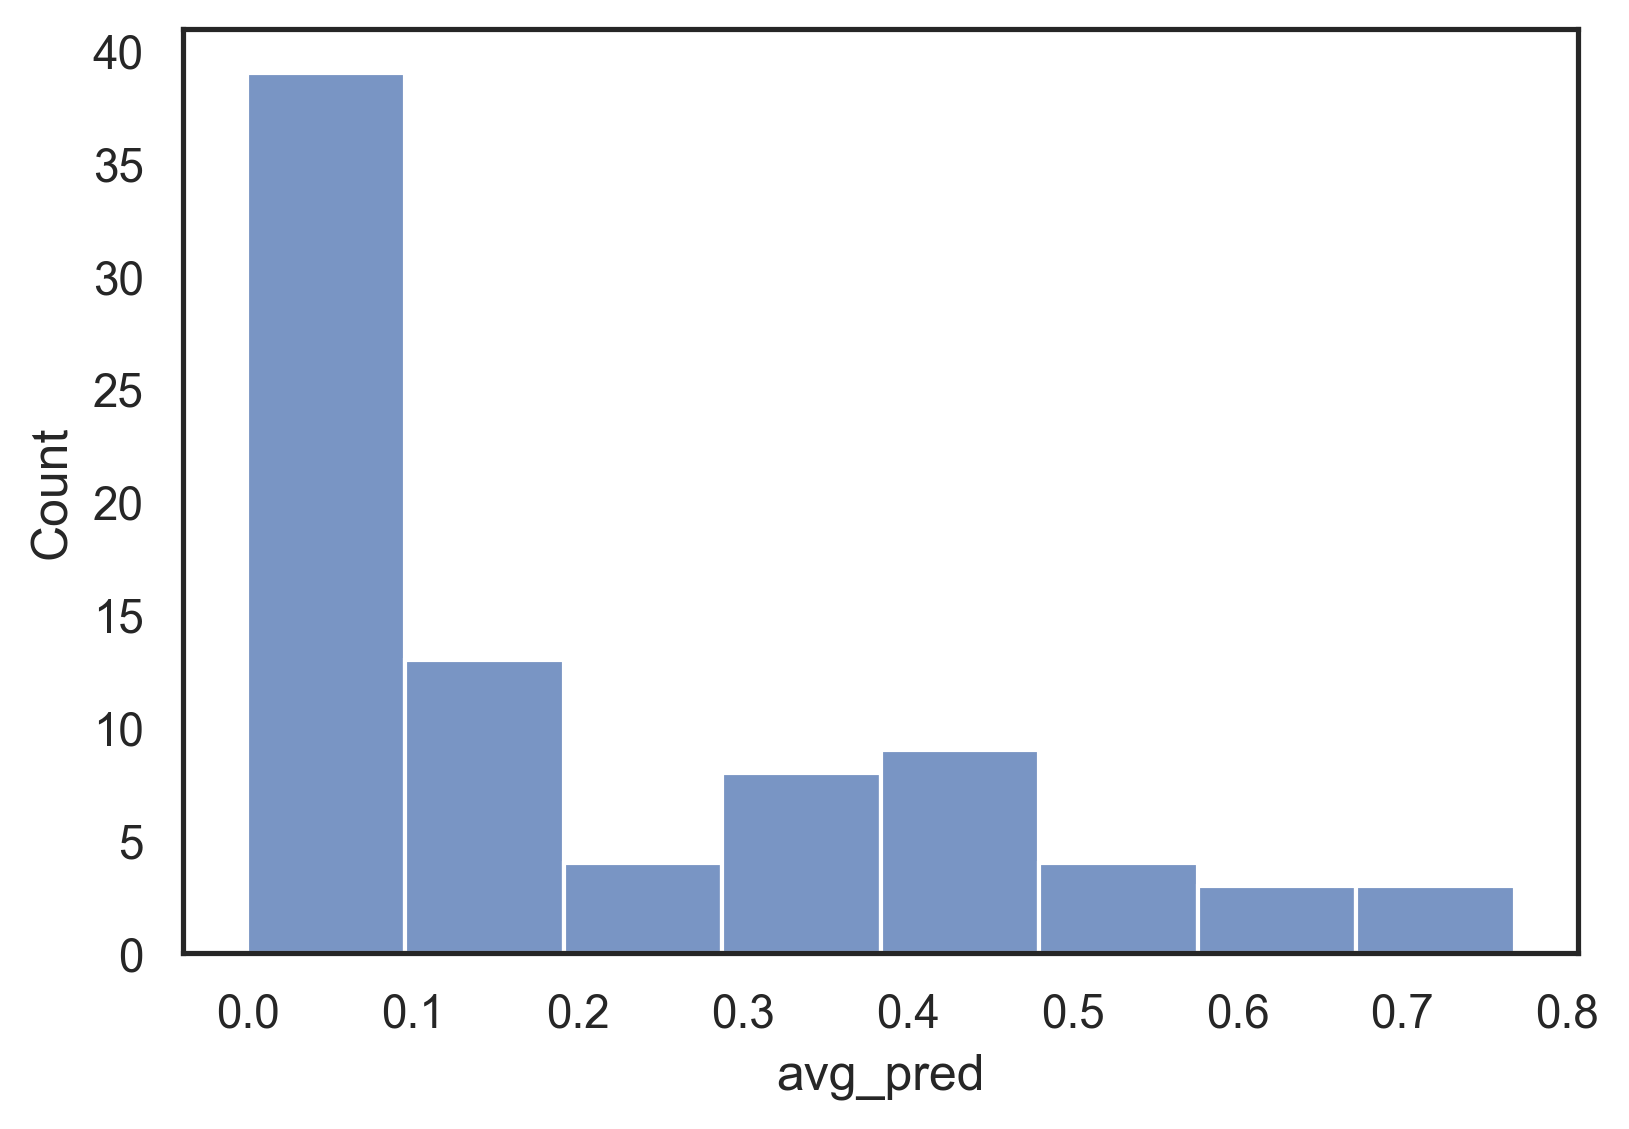

In [33]:
sns.histplot(test_ADs["avg_pred"])

In [21]:
known_DBDs = pd.read_csv("../../../../SFARI/output/lambert_TFs_10-21-24_with_DBD_coords.csv", index_col = 0)
known_DBDs = known_DBDs.dropna()
known_DBDs["DBD_coords_merged"] = known_DBDs["DBD_coords_merged"].str.split("], ")
known_DBDs = known_DBDs.explode("DBD_coords_merged")
known_DBDs["annot_Start"] = known_DBDs["DBD_coords_merged"].str.extract(r'\[(\d+),').astype(int)
known_DBDs["annot_End"] = known_DBDs["DBD_coords_merged"].str.extract(r', (\d+)').astype(int)
# known_RDs["uniprotID"] = known_RDs[0]
# known_RDs = known_RDs[["uniprotID", "annot_Start", "annot_End"]]
known_DBDs["uniprotID"] = known_DBDs["id"].str.split("|").str[1]
known_DBDs

,id,ProteinSeq,DBD_coords_merged,annot_Start,annot_End,uniprotID
0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEA...,"[[221, 243",221,243,A0A087WUV0
0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEA...,"[249, 271",249,271,A0A087WUV0
0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEA...,"[277, 299",277,299,A0A087WUV0
0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEA...,"[305, 327",305,327,A0A087WUV0
0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEA...,"[333, 355",333,355,A0A087WUV0
...,...,...,...,...,...,...
1611,sp|Q9Y6X8|ZHX2_HUMAN Zinc fingers and homeobox...,MASKRKSTTPCMVRTSQVVEQDVPEEVDRAKEKGIGTPQPDVAKDS...,"[271, 317",271,317,Q9Y6X8
1611,sp|Q9Y6X8|ZHX2_HUMAN Zinc fingers and homeobox...,MASKRKSTTPCMVRTSQVVEQDVPEEVDRAKEKGIGTPQPDVAKDS...,"[442, 496",442,496,Q9Y6X8
1611,sp|Q9Y6X8|ZHX2_HUMAN Zinc fingers and homeobox...,MASKRKSTTPCMVRTSQVVEQDVPEEVDRAKEKGIGTPQPDVAKDS...,"[534, 584",534,584,Q9Y6X8
1611,sp|Q9Y6X8|ZHX2_HUMAN Zinc fingers and homeobox...,MASKRKSTTPCMVRTSQVVEQDVPEEVDRAKEKGIGTPQPDVAKDS...,"[633, 685]]",633,685,Q9Y6X8
